In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
import random
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import os
import glob
import uproot3 as uproot
import scipy

from scipy.optimize import curve_fit
import scipy.stats as stats


import mplhep as hep
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use([hep.styles.ATLAS])

from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline

/tmp/ipykernel_185297/1216951868.py:22: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [22]:
theory_pred_floc="/w/halld-scshelf2101/lng/WORK/a2-PWA-Systematics/shared_results/theory_pred/"

In [23]:
def loadDF(fileName,treeName,cols):
    ''' Function to load a root file '''
    tree=uproot.open(fileName)[treeName]
    df=tree.arrays(cols,outputtype=pd.DataFrame).reset_index(drop=True)
    return df

def loadDataInCfgFile(cfg):
    ''' Grab the files listed in a amptools config file '''
    keys=["LOOPDATA","LOOPBKGND","LOOPACCMC"]
    dfs={}
    with open(cfg) as c:
        for line in c.readlines():
            if line.startswith("loop") and "root" in line:
                tmp=line.rstrip().lstrip().split(" ")
                df=[]
                for key in keys:
                    if tmp[1]==key:
                        for f in tmp[2:]:
                            d=loadDF(f,"kin",["Weight","AccWeight","Mpi0eta","cosTheta_eta_hel","cosTheta_eta_gj","Mpi0p","Mpi0","Meta"])
                            if key=="LOOPBKGND":
                                d.Weight*=-1
                            df.append(d)
                        dfs[key]=pd.concat(df)
    return dfs


def loadTheory(tbin):
    ''' Load the theory curves for the different m-projections '''
    theoryCurves=pd.read_csv(theory_pred_floc+"Waves_bin"+str(tbin)+".txt",sep='  ',
                           names=["D0++", "D1++", "D2++", "D1--", "D0+-", "D1+-"], engine='python')
    theoryCurves=theoryCurves.reset_index()
    theoryCurves.rename(columns={"index":"mass"},inplace=True)
    return theoryCurves

def loadMergedPols(fileName,histBaseName,pols):
    '''
    We use amptools' plotter program to make histograms that were output into separate root files
    Use this function to load the root file and grab the histogram you want ~ integrated over some set of polarizations
    '''
    totalValues=0
    for pol in pols:
        hist=uproot.open(fileName)["EtaPi0_"+pol+"_"+histBaseName]
        edges=hist.edges
        width=edges[1]-edges[0]
        value=hist.values
        totalValues+=value
    return totalValues, edges, width

def relBW(x,particle_mass,width):
    ''' Equation for relativistic breit-wigner'''
    gamma=np.sqrt(particle_mass*particle_mass*(particle_mass*particle_mass+width*width))
    k=2*np.sqrt(2)*particle_mass*width*gamma/np.pi/np.sqrt(particle_mass*particle_mass+gamma)
    return k / ((x*x - particle_mass*particle_mass)**2 + (particle_mass*width)**2)

def constructAltTheory(tbin):
    '''
    Everytime we call this we have to load all 5 t bins since we have to keep the same proportions across t-bins
    '''
    theories=[loadTheory(i).iloc[:,1:].sum() for i in range(1,6)]
    theories=[theory/theories[0]["D2++"] for theory in theories]
    theory_masses=loadTheory(1).mass
    theory_waves=loadTheory(1).iloc[:,1:].columns
    
    mapWaves = {wave:relBW(loadTheory(1).mass,1.3182,0.1134)*theories[tbin-1][wave] for wave in theory_waves}
    mapWaves["mass"]=theory_masses
    mapWaves=pd.DataFrame(mapWaves)
    return mapWaves

def getYield(files):
    ''' Quickly get the yield in an tree by integrating the weights '''
    sums=0
    for file in files:
        tmp=uproot.open(file)["kin"].arrays(["Weight"],outputtype=pd.DataFrame)
        sums+=tmp["Weight"].sum()
    return sums

def combineBR(br1,br2,br3):
    ''' Combine 3 branching ratios by multiplication and propagate their uncertainties '''
    br=br1[0]*br2[0]*br3[0]
    brErr=br*np.sqrt((br1[1]/br1[0])**2+(br2[1]/br2[0])**2+(br3[1]/br3[0])**2)
    return [br,brErr]


#################
def loadFitFractions(files):
    ''' 
    amptools' plotter program can also output yields + acceptance corrected yields
    In the current setup the acceptance corrected yields are normalized by the total corrected
    yield to obtain a fit fraction. We can just multiply by the total yield to get the corrected
    yield in a wave
    '''
    etapi_plotter_ofile="etapi_plotter_output.log"
    waveInts_ts={}
    waveIntErrs_ts={}
    totals=[]
    for file in files:
        fname=file+"/"+etapi_plotter_ofile
        with open(fname) as fin:
            for line in fin:
                if "TOTAL EVENTS" in line:
                    total=float(line.split("=")[1].split("+-")[0].rstrip().lstrip())
                    total_err=float(line.split("=")[1].split("+-")[1].rstrip().lstrip())
                if line.startswith("FIT FRACTION") and "::" not in line:
                    wave=line.split(" ")[2]
#                     if "+" in wave or "-" in wave:
#                         continue
                    waveInt=float(line.split(" ")[4].rstrip().lstrip())
                    waveInt_err=float(line.split(" ")[6].rstrip().lstrip())
                    
                    if wave in waveInts_ts:
                        waveInts_ts[wave].append(waveInt)
                        waveIntErrs_ts[wave].append(waveInt_err)
                    else:
                        waveInts_ts[wave]=[waveInt]
                        waveIntErrs_ts[wave]=[waveInt_err]
        totals.append(total)
    
    waveInts_ts={k:np.array(v) for k,v in waveInts_ts.items()}
    waveIntErrs_ts={k:np.array(v) for k,v in waveIntErrs_ts.items()}
    
    return waveInts_ts, waveIntErrs_ts, totals


def applyCut(df,sectionStr):
    tmp=df
    vars1=sectionStr.split(" ")[::3]
    mins1=[float(x) for x in sectionStr.split(" ")[1::3]]
    maxs1=[float(x) for x in sectionStr.split(" ")[2::3]]
    
    for var1,min1,max1 in zip(vars1,mins1,maxs1):
        if var1[0]=='!':
            var1=var1[1:]
            tmp=tmp[~((tmp[var1]>min1)&(tmp[var1]<max1))]
        else:
            tmp=tmp[((tmp[var1]>min1)&(tmp[var1]<max1))]
    return tmp

def getConstraint(sampleCfg,search):
    with open(sampleCfg) as sampleCfg:
        lines=sampleCfg.readlines()
        lines=[line for line in lines if "parameter" in line and "#" not in line]
        lines=[line for line in lines if line.split(" ")[1]==search]
        if len(lines)!=1:
            raise ValueError("Could not extract constraint lines in cfg file")
        lines=lines[0].rstrip().lstrip()
        if "gaussian" in lines:
            mean=float(lines.split(" ")[4])
            uncert=float(lines.split(" ")[5])
        elif "fixed" in lines:
            mean=float(lines.split(" ")[2])
            uncert=0
        else:
            raise ValueError("getConstraint only accepts 'gaussian' or 'fixed' constraints")
    return mean, uncert

In [24]:
### EXTRA
a2_br=[0.145,0.012]
a2prime_br=[0.036,0.011]
eta_br=[0.3941,0.002]
pi0_br=[0.98823,0.00034]
a2FullReact_br=combineBR(a2_br,eta_br,pi0_br)
a2primeFullReact_br=combineBR(a2prime_br,eta_br,pi0_br)
target=1#1.22*1e-9
xerrs=[0.05,0.0625,0.0875,0.125,0.125]
tBinWidths=np.array([0.1,0.125,0.175,0.25,0.25])

flux_floc="/w/halld-scshelf2101/lng/WORK/a2-PWA-Systematics/shared_results/flux/" 

spring_2017_flux=uproot.open(flux_floc+"flux_30274_31057.root")["tagged_lumi"].values[0]
spring_2018_1_flux=uproot.open(flux_floc+"flux_40856_42577.root")["tagged_lumi"].values[0]
fall_2018_8_flux=uproot.open(flux_floc+"flux_50677_51768.root")["tagged_lumi"].values[0]

spring_2017_flux_amo=uproot.open(flux_floc+"flux_AMO_30274_31057.root")["tagged_lumi"].values[0]
spring_2018_1_flux_amo=uproot.open(flux_floc+"flux_AMO_40856_42577.root")["tagged_lumi"].values[0]
fall_2018_8_flux_amo=uproot.open(flux_floc+"flux_AMO_50677_51768.root")["tagged_lumi"].values[0]

phase1_polarized_flux=spring_2017_flux+spring_2018_1_flux+fall_2018_8_flux-spring_2017_flux_amo-spring_2018_1_flux_amo-fall_2018_8_flux_amo
## For the background leakage studies I estimated around 20e13 flux for phase1 between [8,9]. Around 50% of the data would be [8.2,8.8] and
####  then subtracting out around 3% of that does get me around the right number I show below
print(f"phase1 polarized flux: {phase1_polarized_flux:0.3e}")

phase1 polarized flux: 1.036e+02


## Load PWA Cross Section Results

In [25]:
runs=["2017_1","2018_1","2018_8"]
ts=["010020","0200325","0325050","050075","075100"]
midts=np.array([0.1501,0.2560,0.4038,0.6198,0.8691])
tLabels=[f"0.1<t<0.2 $GeV^2$", f"0.2<t<0.325 $GeV^2$", f"0.325<t<0.5 $GeV^2$", f"0.5<t<0.75 $GeV^2$", f"0.75<t<1.0 $GeV^2$"]

In [54]:
pwa_base = "/w/halld-scshelf2101/lng/WORK/a2-PWA-Systematics/nominal_fullWaveset_ReflIndiv_150rnd/final_fullWaveset/"
variations = ["xsec_bootstrap_with_syst", "xsec_minuit_no_syst", "xsec_minuit_with_syst", "xsec_bootstrap_no_syst"]
variation = variations[0]
pwa_xsec = pd.read_csv(f'{pwa_base}/{variation}/results.csv')
crossSection = pwa_xsec['xsec']
crossSectionErr = pwa_xsec['xsec_staterr']

## Load Simple Fit Results and Plot

In [55]:
simple_fit_results=pd.read_csv("/w/halld-scshelf2101/lng/WORK/EtaPi-Analysis/study_pwa/simple_fits/yields.txt",delimiter='\t')

In [56]:
simple_fit_results

,t,form,nsig,nsig_err,normalization,peak,peak_err,width,width_err
0,0.1500,bw,138340.0,12437.40,0.924473,1.30748,0.002125,0.110788,0.010133
1,0.1500,voigt,133642.0,11032.50,0.930771,1.30712,0.002086,0.101059,0.009217
2,0.2625,bw,85440.5,8760.89,0.921271,1.30615,0.003439,0.116202,0.012384
3,0.2625,voigt,82783.4,9932.93,0.927430,1.30567,0.003496,0.106592,0.014610
4,0.4125,bw,52592.9,6338.74,0.923537,1.30840,0.004229,0.111843,0.013902
5,0.4125,voigt,50827.0,5771.52,0.930044,1.30802,0.004134,0.101821,0.012816
6,0.6250,bw,61045.7,6370.99,0.919188,1.31315,0.002604,0.116419,0.012405
7,0.6250,voigt,59080.6,5883.79,0.925487,1.31276,0.002502,0.106768,0.011691
8,0.8750,bw,43736.0,4111.64,0.925709,1.31331,0.002263,0.106616,0.010320
9,0.8750,voigt,42103.0,4908.72,0.932553,1.31290,0.002056,0.096354,0.012794


In [57]:
floc="/w/halld-scshelf2101/lng/WORK/a2-PWA-Systematics/nominal_fullWaveset_ReflIndiv_150rnd/final_fullWaveset/nominal_fullWaveset_ReflIndiv_150rnd/010020/etapi_result_src_samePhaseD.cfg"

pdgs=[]
pdg_errs=[]
mean, uncert = getConstraint(floc,"a2mass")
pdgs.append(mean)
pdg_errs.append(uncert)
mean, uncert = getConstraint(floc,"a2width")
pdgs.append(mean)
pdg_errs.append(uncert)
mean, uncert = getConstraint(floc,"a2massprime")
pdgs.append(mean)
pdg_errs.append(uncert)
mean, uncert = getConstraint(floc,"a2widthprime")
pdgs.append(mean)
pdg_errs.append(uncert)

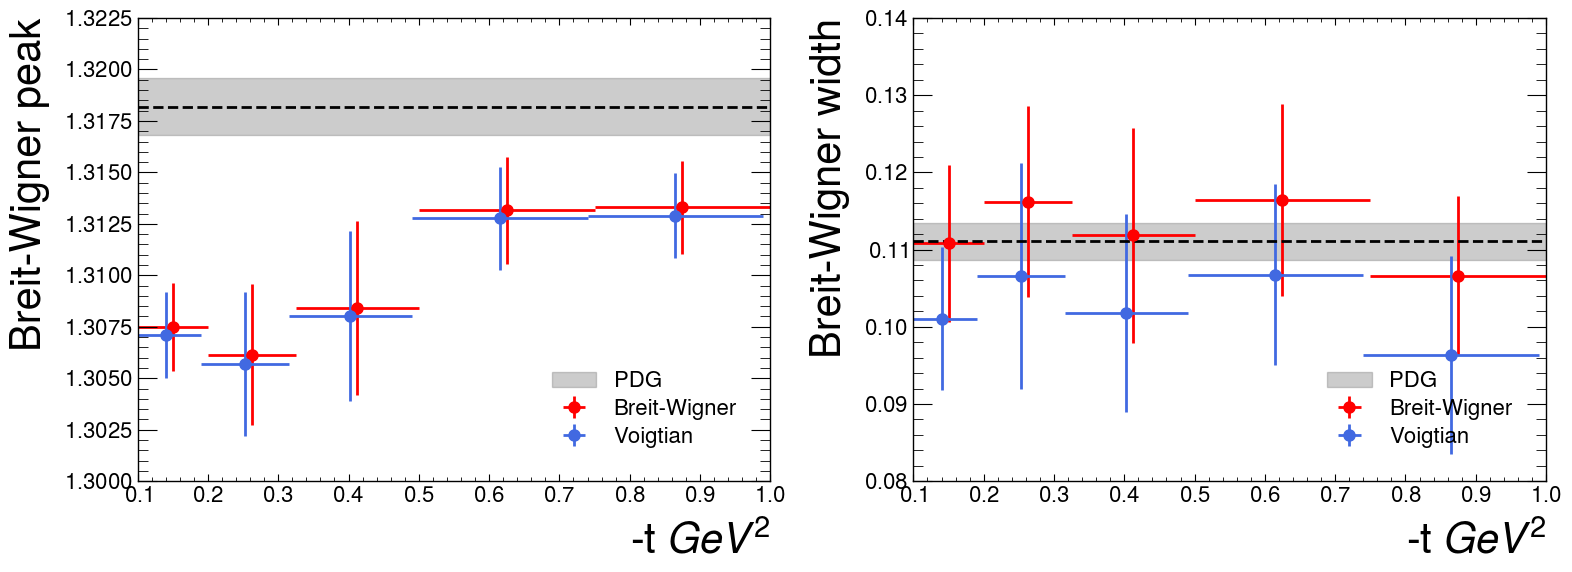

In [58]:
fig,axes=plt.subplots(1,2,figsize=(16,6))

pdg=[1.3177,0.1111] # a2 mass, a2 width
pdg_err=[0.0014,0.0024] 

terr=[0.05,0.0625,0.0875,0.125,0.125]
for i,var in enumerate(["peak","width"]):
    axes[i].errorbar(simple_fit_results[simple_fit_results.form=="bw"].t,
                 simple_fit_results[simple_fit_results.form=="bw"][var],
                 yerr=simple_fit_results[simple_fit_results.form=="bw"][var+"_err"],
                 xerr=terr,fmt='o',c="red",label="Breit-Wigner")
    axes[i].errorbar(simple_fit_results[simple_fit_results.form=="voigt"].t-0.01,
                 simple_fit_results[simple_fit_results.form=="voigt"][var],
                 yerr=simple_fit_results[simple_fit_results.form=="voigt"][var+"_err"],
                 xerr=terr, fmt='o',c="royalblue",label="Voigtian")

    axes[i].axhline(pdgs[i],linestyle='--',c='black')
    axes[i].axhspan(pdgs[i]-pdg_err[i],pdgs[i]+pdg_err[i],alpha=0.4,color='gray',label="PDG")
    axes[i].legend(loc=4)
    axes[i].set_xlim(0.1,1.0)
    axes[i].set_ylabel("Breit-Wigner "+var,size=30)
    axes[i].set_xlabel(r"-t $GeV^{2}$",size=30)
plt.tight_layout()

In [59]:
baseTheoryFolder=theory_pred_floc
bapa_theory=pd.read_csv(baseTheoryFolder+"Ten_A2_Fit_85GeV.txt",delimiter=";")
bapa_theory=bapa_theory[["beam asymmetry"]]
bapa_theory.columns=["ba"]

crossSection_theory=pd.read_csv(baseTheoryFolder+"Bands_TMD_A2.txt", delim_whitespace=True, header=None)
crossSection_theory=crossSection_theory.loc[:,[0,7,8,9]]
crossSection_theory.columns=["t","cs_low_err","cs","cs_up_err"]

psig_theory=pd.read_csv(baseTheoryFolder+"Psig_Bands_TMD_A2.txt", delim_whitespace=True, header=None)
psig_theory=psig_theory.loc[:,[7,8,9]]
psig_theory.columns=["pa_low_err","pa","pa_up_err"]

crossSection_theory=pd.concat([crossSection_theory,psig_theory,bapa_theory],axis=1)
crossSection_theory["cs_low_err"]=crossSection_theory["cs"]-crossSection_theory["cs_low_err"]
crossSection_theory["cs_up_err"]=crossSection_theory["cs_up_err"]-crossSection_theory["cs"]
crossSection_theory["pa_low_err"]=crossSection_theory["pa"]-crossSection_theory["pa_low_err"]
crossSection_theory["pa_up_err"]=crossSection_theory["pa_up_err"]-crossSection_theory["pa"]
crossSection_theory=crossSection_theory[(crossSection_theory.t<1)&(crossSection_theory.t>0.1)]

crossSection_theory=crossSection_theory[(crossSection_theory.t<1)&(crossSection_theory.t>0.1)]

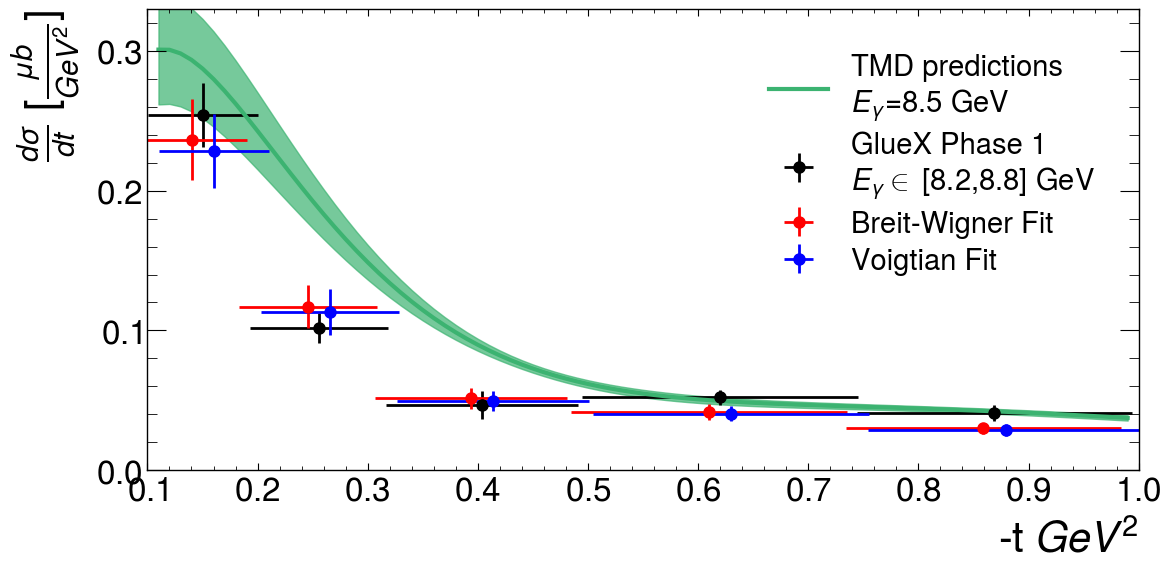

In [63]:
## Polarized flux basically no error bars 
dists=["bw","voigt"]
distsPretty=["Breit-Wigner","Voigtian"]

cs={}
csErrs={}
for dist,distPretty in zip(dists,distsPretty):
    simpleFit_corrected_yields=simple_fit_results[simple_fit_results.form==dist].nsig
    simpleFit_corrected_yield_errs=simple_fit_results[simple_fit_results.form==dist].nsig_err
    simpleFit_crossSection=simpleFit_corrected_yields/phase1_polarized_flux/target/a2FullReact_br[0]/tBinWidths
    simpleFit_crossSectionErr=simpleFit_crossSection*np.sqrt( 
        (simpleFit_corrected_yield_errs/simpleFit_corrected_yields)*(simpleFit_corrected_yield_errs/simpleFit_corrected_yields)+
        (a2FullReact_br[1]/a2FullReact_br[0])*(a2FullReact_br[1]/a2FullReact_br[0])
                                        )
    # nb to microbarns
    simpleFit_crossSection/=1e6
    simpleFit_crossSectionErr/=1e6
    
    cs[dist]=simpleFit_crossSection
    csErrs[dist]=simpleFit_crossSectionErr

fig,axes=plt.subplots(1,1,figsize=(12,6))

arbitraryFactor=1
axes.errorbar(midts,crossSection,fmt='o',xerr=xerrs,yerr=crossSectionErr,c='black',
                 label="GlueX Phase 1\n$E_{\gamma}\in$ [8.2,8.8] GeV")
for dist,distPretty,color in zip(dists,distsPretty,['red','blue']):
    shift = -0.01 if dist=="bw" else 0.01
    axes.errorbar(midts+shift,cs[dist],fmt='o',xerr=xerrs,yerr=csErrs[dist],c=color,
                     label=distPretty+" Fit")
axes.set_xlabel(r"-t $GeV^2$",size=30)
axes.set_ylabel(r"$\frac{d\sigma}{dt}$ [$\frac{\mu b}{GeV^2}$]",size=30)
axes.plot(crossSection_theory["t"],crossSection_theory["cs"]/arbitraryFactor,c="mediumseagreen",linewidth=3,
             label="TMD predictions\n$E_{\gamma}$=8.5 GeV")
axes.fill_between(crossSection_theory["t"],
                      (crossSection_theory["cs"]-crossSection_theory["cs_low_err"])/arbitraryFactor,
                      (crossSection_theory["cs"]+crossSection_theory["cs_up_err"])/arbitraryFactor,
                      color="mediumseagreen",alpha=0.7)
axes.tick_params(axis='both',labelsize=24)
axes.set_xlim(0.1,1.0)
axes.set_ylim(0,0.33)
axes.ticklabel_format(style='plain')
axes.legend(prop={"size":21})
plt.tight_layout()


plt.savefig("/w/halld-scshelf2101/lng/WORK/EtaPi-Analysis/study_pwa/simple_fits/simpleFits_comparison.pdf")

In [61]:
bw=simple_fit_results[simple_fit_results.form=="bw"].nsig.values
voigt=simple_fit_results[simple_fit_results.form=="voigt"].nsig.values
[f"{ele*100:0.1f}%" for ele in (bw-voigt)/bw]

['3.4%', '3.1%', '3.4%', '3.2%', '3.7%']